# Перенос стилей

Почитать:
* [PyTorch, style transfer tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)
* [Оригинальная статья](https://arxiv.org/abs/1508.06576)

<img src="https://cdn-images-1.medium.com/max/1600/1*XI3beonBnOwp-y5BwNOqCw.gif" width="500">

**Quiz: как вы думаете, кто на картинке?**

# Основные принципы


1. Принимаем на вход 3 картинки: `content_image`, `style_image`, `input_image`;

2. Вводим два расстояния, которые конкретно определим позже:
 * $D_C$ (distance content) —  измеряет насколько близки по **контенту** 2 картинки;
 * $D_S$ (distance style) — измеряет насколько близки по **стилю** 2 картинки;

3. Для картинки `input_image` одновременно минимизируем расстояния $D_C$ до `content_image` и $D_S$ `style_image`: её входные пиксели можно просто считать обучаемыми параметрами, которые можно подобрать градиентным спуском

<img src="https://pytorch.org/tutorials/_images/neuralstyle.png">

In [223]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
import torchvision.models as models

import copy

Хоть нам и не нужно тут ничего обучать, GPU всё равно не помешает: чем мельче будут шаги, тем лучше получится результат.

In [224]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Качаем картинки

<img src="https://thumbs.gfycat.com/FaithfulSickDuckbillcat-max-1mb.gif">



In [ ]:
from google.colab import drive
drive.mount('gdrive')

In [ ]:
%cd gdrive/MyDrive/Materials/

In [ ]:
# уменьшаем картинки
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)), # уменьшаем картинку
    transforms.ToTensor()])  # делаем из картинки тензор


def image_loader(image_name):
    image = Image.open(image_name)
    # создаем фейковый дименшн для батча
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("style_image_1.jpg")
content_img = image_loader("content_image_1.jpg")

assert style_img.size() == content_img.size(), \
    "Картинки для стиля и для контента должны быть одного размера"

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])



Конвертируем картинку обратно из тензора в формат `PIL` и показываем ее с помощью `plt.imshow()`.

In [ ]:
unloader = transforms.ToPILImage()  # конвертируем в `PIL image`

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)      # убираем лишнюю размерность батча
    image = unloader(image)
    return image


## Loss

### Content Loss

* Принимаем на вход фичи из прошлого сверточного слоя для `content_image` — $F_{CL}$ — и то же самое для input_image — $F_{XL}$. Считаем расстояние между ними и называем это $D_C^L(X,C) = \|F_{XL} - F_{CL}\|^2$. 
* Расстояние считаем с помощью `nn.MSELoss`.
* Реализуем все это дело как модуль. Само расстояние $D_C^L(X,C)$ в нем хранится как параметр.

In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super().__init__()
        # detach() используется, чтобы не считать градиенты до target
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### Style Loss

* Берем матрицу $F_{XL}$, размерностью $[a,b,c,d]$, делаем размерность $[a\cdot b, c \cdot d]$
* Считаем матрицу Грама $G_{XL}$ для этой матрицы: это перемножение матрицы на свою транспонированную копию.
* Нормализуем матрицу Грама: делим каждое ее значение на полное количество элементов в матрице. Это необходимо сделать, чтобы операция получения матрицы Грама не повлияла на повышение активации нейронов.

In [ ]:
# upd: возможно, эта штука уже есть где-то в pytorch

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Модуль для `StyleLoss` выглядит также, как модуль для `ContentLoss`,

с той разницей, что теперь MSE считается для двух матриц Грама $\|G_{XL}$ - $G_{SL}\|^2$, а не для активаций слоев непосредственно.



In [ ]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Используем предобученную модель

<img src="https://cdn-images-1.medium.com/max/1600/1*Fe6z8VdUS6laTd6Ev3EohQ.gif">

Импортируем наш любимый vgg и ставим его в режим `eval()` — в нём некоторые слои работают по-разному в режимах предсказания и обучения.

В оригинальной статье про NST использовали vgg19, что автор и будет, но при желании можете использовать вашу любимую свёрточную сеть, если корректно подберете параметры.

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]


Как и в тетрадке про Deep Dream, используем `mean=[0.485, 0.456, 0.406]` и `std=[0.229, 0.224, 0.225]`, так как оригинальная VGG обучалась с такими параметрами препроцессинга для входных данных.

In [ ]:
# upd: эта штука тоже уже должна быть где-нибудь в pytorch

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Делаем модуль для нормализации, чтобы потом без труда стакать в слои
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = mean.view(-1, 1, 1).clone()
        self.std = std.view(-1, 1, 1).clone()

    def forward(self, img):
        return (img - self.mean) / self.std

Мы создаем новый `Sequential` модуль содержащий те же модули, что и `vgg19.features`, только теперь нам нужно добавить наш лосс после каждого сверточного слоя, который мы хотим использовать.

In [ ]:
# Какие именно слои мы хотим использовать чтобы считать наши лоссы
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # помним, что сначала нормализуем картинки
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # хотим иметь iterable с вставленными модулями
    content_losses = []
    style_losses = []

    # создаем свою модельку, в которую вставим лоссы
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # добавляем content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # добавляем style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # Обрезаем все слои, которые находятся после последнего ContentLoss или StyleLoss
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Чаще всего в качестве `input_image` используется та же картинка что и `content_image`. Но также можно использовать и шумную картинку и посмотреть что получится тогда.


Gradient Descent
----------------

Оптимизируем `input_image` используя `L-BFGS` оптимизатор, как советует автор оригинальной статьи вот [здесь](https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq).


In [ ]:
def get_input_optimizer(input_img):
    # input_img - это параметры, до которых доходит градиент
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

# Finally

<img src="http://rux.vc/wp-content/uploads/2016/08/cat-out-2.gif">

* Итеративно меняем `input_image`; для того параметр `num_steps`;
* Можно менять веса стиля и веса контента `style_weight`, `content_weight`;
* Корректируем значения картинки так, чтобы они не выходили за пределы `[0..1]`
* В функции `closure` мы собираем весь лосс из всех модулей, считаем градиенты.
* Затем обновляем параметры модели с помощью `optimizer.step(closure)`

In [ ]:
def run_style_transfer(normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=320,
                       style_weight=1000000, content_weight=1):
    """ Поехали! """
    
    print('Building the style transfer model..')
    cnn = models.vgg19(pretrained=True).features.to(device).eval()
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean,
                                                                     normalization_std,
                                                                     style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # корректируем значения, чтобы они лежали в пределах `[0..1]`
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 300 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # корректируем значения, чтобы они лежали в пределах `[0..1]` для финальной картинки
    input_img.data.clamp_(0, 1)

    return input_img

Запускаем!


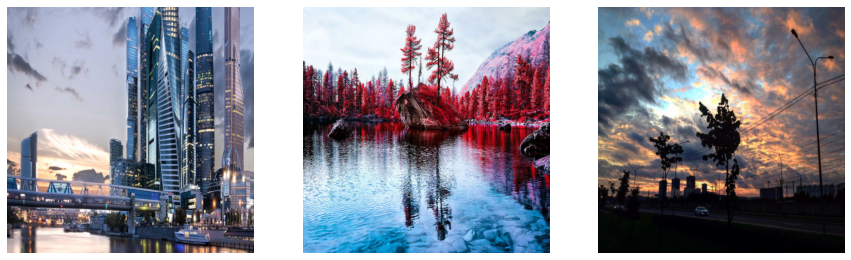

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 15))

for i, ax in enumerate(axs):
    ax.imshow(imshow(image_loader(f'content_image_{i + 1}.jpg')))
    ax.axis('off')


In [ ]:
content_paths = ['content_image_1.jpg',
                 'content_image_2.jpg',
                 'content_image_3.jpg'
                 ]

style_paths = ['style_image_1.jpg',
               'style_image_2.jpg',
               'style_image_3.jpg'
                 ]

outputs_imgs = {}


for style_path in style_paths:
    style_img = image_loader(style_path)
    outputs_imgs[style_path] = []
    for content_path in content_paths:
        print(f'Current style: {style_path}...')
        print(f'Current image: {content_path}...')

        content_img = image_loader(content_path)
        input_img = content_img.clone()
        output = run_style_transfer(cnn_normalization_mean, 
                                    cnn_normalization_std, 
                                    content_img, style_img, 
                                    input_img, 
                                    num_steps=600, 
                                    content_weight=1e-2, 
                                    style_weight=100000)
        outputs_imgs[style_path].append(output) 
        

Current style: style_image_1.jpg...
Current image: content_image_1.jpg...
Building the style transfer model..
Optimizing..
run [300]:
Style Loss : 0.236760 Content Loss: 0.263980

run [600]:
Style Loss : 0.036073 Content Loss: 0.190558

Current style: style_image_1.jpg...
Current image: content_image_2.jpg...
Building the style transfer model..
Optimizing..
run [300]:
Style Loss : 0.218875 Content Loss: 0.273395

run [600]:
Style Loss : 0.049071 Content Loss: 0.203575

Current style: style_image_1.jpg...
Current image: content_image_3.jpg...
Building the style transfer model..
Optimizing..
run [300]:
Style Loss : 1687.655273 Content Loss: 0.349452

run [600]:
Style Loss : 0.110706 Content Loss: 0.234036

Current style: style_image_2.jpg...
Current image: content_image_1.jpg...
Building the style transfer model..
Optimizing..
run [300]:
Style Loss : 0.299307 Content Loss: 0.409837

run [600]:
Style Loss : 0.039288 Content Loss: 0.293501

Current style: style_image_2.jpg...
Current image

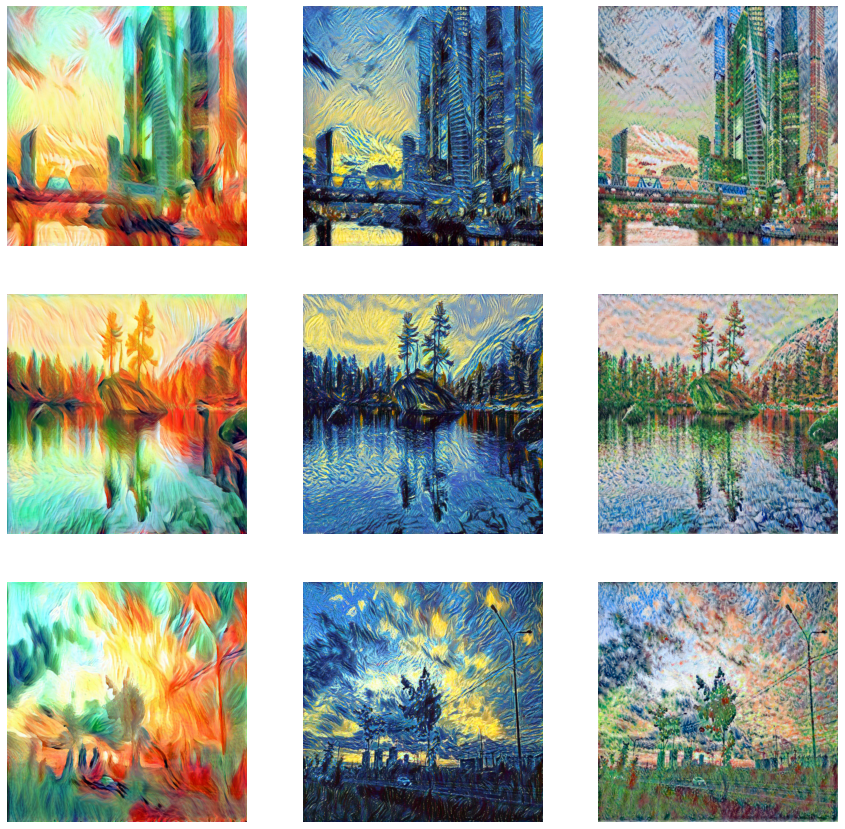

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for row, ax in enumerate(axs):
    for col, plot in enumerate(ax):
        if col == 0:
            plot.imshow(imshow(outputs_imgs['style_image_1.jpg'][row]))
            plot.axis('off')
        
        elif col == 1:
            plot.imshow(imshow(outputs_imgs['style_image_2.jpg'][row]))
            plot.axis('off')

        
        elif col == 2:
            plot.imshow(imshow(outputs_imgs['style_image_3.jpg'][row]))
            plot.axis('off')



In [ ]:
i = 0
for k, imgs in outputs_imgs.items():
    mult = 1
    for img in imgs:
        image = imshow(img)
        image.save(f'styled_img_{i * mult}.jpg', format='JPEG')
        i += 1
    mult += 1
